In [28]:
OUTPUT_PATH = "../../visualization/assets/"

# Read tile_placements.csv into a Pandas DataFrame

In [1]:
#conda install pytables seaborn imageio

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from skimage.draw import polygon
import json
from collections import OrderedDict
from copy import deepcopy
import pickle as pkl
import torch
import torch.nn as nn
import torch.nn.functional as F
import math
from math import floor
import imageio
import os
from ipywidgets import IntProgress
from tqdm import tqdm_notebook

In [2]:
csv = pd.read_csv("tile_placements.csv", header=0)

In [3]:
csv.ts = (csv.ts.values-csv.ts.min())//1000

In [4]:
users = pd.DataFrame(csv.user.unique())
users.columns = ["user"]
users.head(10)

,user
0,c2Md9m4QckH8M+lhNh9btgoiFDk=
1,5KjCuLCk/VTXBIgaszopYecZ3uU=
2,toyjOAoAZMtlGZ3hXm5/LYsi+iA=
3,TGENUMJ6VmaBRr8ae9yP0MWQ66g=
4,usR8PLvN90gdivTbszEqhvPcXI4=
5,PhCeV35qg+Kd4HZH2A8YsmwE65w=
6,h36EHV8mxPdVf6/KSVcVJdQD+3g=
7,Fs34pA4xcfKSvw/c+kS+P31aB+s=
8,JSi4ekmizWOUcjae6TFFCLUGeH8=
9,otYEXzF2K9RLO0VCBSS/bpOcek4=


In [5]:
place = csv.merge(users.reset_index().rename(columns={"index":"user_id"}), left_on="user", right_on="user")
place.drop(columns=["user"], inplace=True)
place.sort_values("ts", inplace=True)
place = place[["ts", "user_id", "x_coordinate", "y_coordinate", "color"]]
place.reset_index(inplace=True)
place.drop(columns=["index"], inplace=True)
place.head(20)

,ts,user_id,x_coordinate,y_coordinate,color
0,0,89488,505,510,1
1,40,89488,490,504,1
2,93,89488,518,498,0
3,649,371383,474,495,11
4,661,371383,477,495,11
5,673,371383,472,496,11
6,691,371383,473,497,11
7,710,371383,474,498,11
8,722,371383,475,498,11
9,738,371383,476,498,11


In [6]:
place.to_hdf("place.hdf", "place", mode="w", format="t", data_columns=True)
users.to_hdf("place.hdf", "users", mode="a", format="t")

In [7]:
place = pd.read_hdf("place.hdf", "place", mode="r")
users = pd.read_hdf("place.hdf", "users", mode="r")

---------------------------

# Build communities

In [121]:
def get_community_mask(atlas_with_pixels, atlas_id, kernel_size=5):
    """
    Compute a 1000x1000 binary matrix for the pixels that are in a community
    """
    mask = np.zeros((1010, 1010), dtype=np.float32)
    mask[tuple(zip(*atlas_with_pixels[atlas_id]["fullpixels"]))] = 1
    mask = mask[:1000, :1000]
    MK = 1000 // kernel_size
    NL = 1000 // kernel_size
    mask = mask[:MK*kernel_size, :NL*kernel_size].reshape(MK, kernel_size, NL, kernel_size).mean(axis=(1, 3))
    res = np.zeros((1000//kernel_size, 1000//kernel_size), dtype=np.uint8)
    res[mask>.5]= 255
    return res.T

## Build pixels coordinates from masks

In [97]:
with open("atlas_cleaned.json", mode="r") as f:
    atlas = json.load(f)

In [102]:
atlas_with_pixels = {}
for commu in atlas:
    name = commu["name"].lower()
    if len(commu["path"])>0 and not ("covered" in name or "former" in name or "incomplete" in name):
        c = {}
        c["id"] = commu["id"]
        c["name"] = commu["name"]
        c["description"] = commu["description"]
        c["subreddit"] = commu["subreddit"]
        rr, cc = polygon(*zip(*commu["path"]))
        c["fullpixels"] = set(zip(rr, cc))
        atlas_with_pixels[commu["id"]] = c

### Remove smaller communities from bigger ones

In [ ]:
by_area = {}
for idx, commu in atlas_with_pixels.items():
    l = len(commu["fullpixels"])
    if l not in by_area:
        by_area[l] = set()
    by_area[l].add(idx)

In [107]:
areas = list(sorted(by_area.keys()))[1:]
for i, area in enumerate(areas):
    for cur_idx in by_area[area]:
        pixs = deepcopy(atlas_with_pixels[cur_idx]["fullpixels"])
        for j in areas[:i]:
            for idx in by_area[j]:
                pixs = pixs - atlas_with_pixels[idx]["fullpixels"]
        atlas_with_pixels[cur_idx]["partialpixels"] = pixs

In [118]:
with open("atlas_with_pixels.pkl", mode="wb") as f:
    pkl.dump(pixels, f)

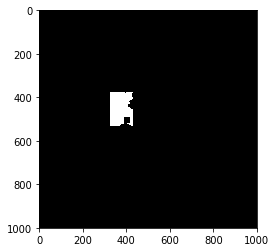

In [119]:
atlas_id = 2
mask = np.zeros((1000, 1000))
mask[tuple(zip(*atlas_with_pixels[atlas_id]["partialpixels"]))] = 1
plt.figure(figsize=(4,4))
plt.imshow(mask.T, cmap="gray")

In [12]:
with open("atlas_with_pixels.pkl", mode="rb") as f:
    pixels = pkl.load(f)

## Get color that win for each pixels

In [138]:
START_TIME = 194400 # == 3/4 of 72h
#START_TIME = 129600 # == 1/2 of 72h

In [139]:
with pd.HDFStore("place.hdf", mode="r") as store:
    place = store.place
place = place[place.ts>=60845]
place.ts = place.ts - 60845

In [140]:
lasts_pixels = place.groupby(by=["x_coordinate", "y_coordinate"]).tail(5)

In [141]:
counts = lasts_pixels.groupby(by=["x_coordinate", "y_coordinate", "color"]).count()
pixels_color = counts.sort_values("ts", ascending=False).groupby(["x_coordinate", "y_coordinate"]).head(1)

In [142]:
place_by_winning_color = place.set_index(["x_coordinate", "y_coordinate", "color"]).loc[pixels_color.index.values]
place_by_winning_color.reset_index(level="color", inplace=True)

In [148]:
print("# remaining users =", len(place_by_winning_color[place_by_winning_color.ts>=START_TIME].user_id.unique()))

# remaining users = 420476


In [149]:
print("# remaining edits =", len(place[place.user_id.isin(place_by_winning_color[place_by_winning_color.ts>=START_TIME].user_id.unique())]))

# remaining edits = 12567698


In [152]:
for i, commu in atlas_with_pixels.items():
    if i % 10 == 0:
        print(".", end="")
    if "partialpixels" in commu and len(commu["partialpixels"])>100:
        commu["users"] = place_by_winning_color.loc[place_by_winning_color.index.intersection(list(commu["partialpixels"]))].user_id.unique()
    else:
        commu["fullpixels"] = set()
        cummu["partialpixels"] = set()
        commu["users"] = set()

........................................................................................................................................................

In [153]:
with open("atlas_with_pixels.pkl", mode="wb") as f:
    pkl.dump(atlas_with_pixels, f)

------------
# Generate levelmaps

## Load place

In [154]:
with pd.HDFStore("place.hdf", mode="r") as store:
    print(store.keys())
    place = store.place
    users = store.users

['/place', '/users']


In [155]:
place.describe()

,ts,user_id,x_coordinate,y_coordinate,color
count,1.655990e+07,1.655990e+07,1.655990e+07,1.655990e+07,1.655990e+07
mean,2.139252e+05,2.314466e+05,4.730365e+02,5.154545e+02,5.733436e+00
std,6.689361e+04,2.229644e+05,2.882131e+02,2.996301e+02,4.437919e+00
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,1.684950e+05,6.805400e+04,2.290000e+02,2.610000e+02,3.000000e+00
50%,2.249860e+05,1.619120e+05,4.590000e+02,5.080000e+02,5.000000e+00
75%,2.657800e+05,3.268200e+05,7.120000e+02,7.870000e+02,9.000000e+00
max,3.200460e+05,1.166923e+06,1.000000e+03,1.000000e+03,1.500000e+01


In [156]:
place = place[place.ts>=60845]
place.ts = place.ts - 60845

## Smoothing functions

In [157]:
def get_edits(place, _from, _to):
    canevas = place[(place.ts>=_from)&(place.ts<_to)]
    counts = canevas.shape[0]
    if counts == 0:
        return np.zeros((1000, 1000), dtype=np.float32), 0
    
    canevas = canevas.pivot_table(values="ts", index="y_coordinate", columns="x_coordinate", aggfunc=lambda x: len(x))
    canevas = canevas.reindex(index=np.arange(1001), columns=np.arange(1001))
    canevas_matrix = canevas.fillna(0).values[:-1, :-1]
    return canevas_matrix.astype(np.float32), counts

In [160]:
"""
def get_gaussian_kernel(kernel_size=3, sigma=2, channels=1):
    # Create a x, y coordinate grid of shape (kernel_size, kernel_size, 2)
    x_coord = torch.arange(kernel_size)
    x_grid = x_coord.repeat(kernel_size).view(kernel_size, kernel_size)
    y_grid = x_grid.t()
    xy_grid = torch.stack([x_grid, y_grid], dim=-1).float()

    mean = (kernel_size - 1)/2.
    variance = sigma**2.

    # Calculate the 2-dimensional gaussian kernel which is
    # the product of two gaussian distributions for two different
    # variables (in this case called x and y)
    gaussian_kernel = (1./(2.*math.pi*variance)) *\
                      torch.exp(
                          -torch.sum((xy_grid - mean)**2., dim=-1) /\
                          (2*variance)
                      )

    # Make sure sum of values in gaussian kernel equals 1.
    gaussian_kernel = gaussian_kernel / torch.sum(gaussian_kernel)

    # Reshape to 2d depthwise convolutional weight
    gaussian_kernel = gaussian_kernel.view(1, 1, kernel_size, kernel_size)
    gaussian_kernel = gaussian_kernel.repeat(channels, 1, 1, 1)

    gaussian_filter = nn.Conv2d(in_channels=channels, out_channels=channels,
                                kernel_size=kernel_size, groups=channels, bias=False)

    gaussian_filter.weight.data = gaussian_kernel
    gaussian_filter.weight.requires_grad = False
    
    return gaussian_filter
"""
None

In [161]:
def create_canevas_tensors(place, windows_start, window_size=15*60):
    tss = []
    edits_counts = []
    batch = []
    for ts in windows_start: #range(place.ts.min(), place.ts.max()+w_size, w_size):
        tss.append(ts)
        canevas, counts = get_edits(place, ts, ts+w_size)
        #print(canevas.max())
        edits_counts.append(counts)
        batch.append(canevas)
    tensor_batch = torch.cat([torch.Tensor(m).unsqueeze(0) for m in batch])
    tensor_batch.unsqueeze_(1)
    return tss, edits_counts, tensor_batch

In [163]:
class Smoother():
    def __init__(self, kernel, sigma, mean_pooling=False, cuda=1):
        self.cuda = cuda
        self.kernel = nn.AvgPool2d(kernel, kernel) if mean_pooling else nn.MaxPool2d(kernel, kernel)  
        if cuda != None:
            self.kernel = self.kernel.cuda(cuda)
        
    def __call__(self, image_tensor):
        if self.cuda is not None:
            image_tensor = image_tensor.cuda(self.cuda)
        smoothed = self.kernel(image_tensor)
        maxs, _ = smoothed.view(smoothed.size(0), -1).max(-1)
        return smoothed.cpu().numpy().squeeze(1), maxs.cpu().numpy().squeeze()

In [164]:
def generate_levelmaps(place, smoother, ts_window, community_id=None, users_id=None, img_path=None, json_path=None):
    windows_start = range(place.ts.min(), place.ts.max()+1, w_size)
    
    if community_id is not None:
        place = place[place.user_id.isin(users_id)]
        print(f"Community {community_id}" + "-"*10)
    else:
        community_id = "global"
        
    tss, edits_counts, canevas_tensor = create_canevas_tensors(place, windows_start, ts_window)
    smoothed, maxs = smoother(canevas_tensor)
    
    print("Tiles generated and smoothed, saving images")
    path = f"{img_path}/{community_id}"
    os.makedirs(path, exist_ok=True)
    
    for i in range(len(tss)):
        imageio.imwrite(f"{path}/{i}.png", (255*smoothed[i]/max(1,smoothed[i].max())).astype(np.uint8), optimize=True)

    index = [{"idx":i, "ts":tss[i], "max":round(float(maxs[i]),5), "counts":edits_counts[i]} for i in range(len(tss))]
    
    os.makedirs(json_path, exist_ok=True)
    with open(f"{json_path}/{community_id}.json", "w") as f:
        json.dump(index, f)
        print(f"Images saved to {path}")
    return index

## Apply smoothing

In [177]:
mode = "max"
img_path = f"../../visualization/assets/img/levelmaps/{mode}"
json_path = f"../../visualization/assets/json/levelmaps/{mode}"

w_size = 30*60
strides = 5
sigma = 1
mean_pooling = mode == "mean"
n_biggest_communities = 150
used_pixels = pixels

smoother = Smoother(strides, sigma, mean_pooling, cuda=1)

In [178]:
generate_levelmaps(place, smoother, w_size, None, None, img_path, json_path)

community_ids = []
for k in sorted(atlas_with_pixels.keys(), key=lambda id: len(atlas_with_pixels[id]["partialpixels"]) if "partialpixels" in atlas_with_pixels[id] else -1, reverse=True)[:n_biggest_communities]:
    community_ids.append(k)
    generate_levelmaps(place, smoother, w_size, k, atlas_with_pixels[k]["users"], img_path, json_path)
    imageio.imwrite(f"{img_path}/{k}/mask.png", get_community_mask(atlas_with_pixels, k, strides), optimize=True)

Tiles generated and smoothed, saving images
Images saved to ../../visualization/assets/img/levelmaps/max/global
Community 75----------
Tiles generated and smoothed, saving images
Images saved to ../../visualization/assets/img/levelmaps/max/75
Community 286----------
Tiles generated and smoothed, saving images
Images saved to ../../visualization/assets/img/levelmaps/max/286
Community 360----------
Tiles generated and smoothed, saving images
Images saved to ../../visualization/assets/img/levelmaps/max/360
Community 46----------
Tiles generated and smoothed, saving images
Images saved to ../../visualization/assets/img/levelmaps/max/46
Community 2----------
Tiles generated and smoothed, saving images
Images saved to ../../visualization/assets/img/levelmaps/max/2
Community 235----------
Tiles generated and smoothed, saving images
Images saved to ../../visualization/assets/img/levelmaps/max/235
Community 637----------
Tiles generated and smoothed, saving images
Images saved to ../../visualiz

In [182]:
community_ids = set(community_ids)

atlas_out = []
for comm in atlas_with_pixels.values():
    if comm["id"] in community_ids:
        c = dict()
        c["id"] = comm["id"]
        c["name"] = comm["name"]
        c["description"] = comm["description"]
        c["subreddit"] = comm["subreddit"]
        atlas_out.append(c)

path = f"../../visualization/assets/json/{mode}/"
os.makedirs(path, exist_ok=True)
with open(path+"communities.json", "w") as f:
    json.dump(atlas_out, f)   